# Driver Drowsiness Detection

## Import necessary libraries

In [2]:
import dlib
import joblib
import cv2
from imutils import face_utils
from scipy.spatial import distance
import math
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
p = "/content/drive/MyDrive/DDD/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)
warnings.filterwarnings("ignore")

## Load KNN model

### KNN Model

In [3]:
neigh = joblib.load("/content/drive/MyDrive/DDD/KNN.joblib")

### Random Forest Model

In [4]:
forest = joblib.load("/content/drive/MyDrive/DDD/RandomForest_82.joblib")

## Feature computation functions

In [6]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye

## Smoothing with window size 1000
def average(y_pred, window_size=1000):
    for i in range(len(y_pred)):
        if i < window_size or i >= len(y_pred) - window_size:
            pass
        else:
            average = float(sum(y_pred[i-window_size:i+window_size+1])) / (2*window_size+1)
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred


##  Model

In [7]:
def model(landmarks, algorithm):

    features = pd.DataFrame(columns=["EAR","MAR","CIR","MOE"])
    eye = landmarks[36:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)

    df = pd.concat([features, pd.DataFrame({"EAR":ear,"MAR": mar,"CIR": cir,"MOE": mouth_eye}, index=[0])], ignore_index=True)


    df["EAR_N"] = (df["EAR"]-mean["EAR"])/ std["EAR"]
    df["MAR_N"] = (df["MAR"]-mean["MAR"])/ std["MAR"]
    df["CIR_N"] = (df["CIR"]-mean["CIR"])/ std["CIR"]
    df["MOE_N"] = (df["MOE"]-mean["MOE"])/ std["MOE"]

    Result = algorithm.predict(df)

    if Result == 1:
        Result_String = "Drowsy"
    else:
        Result_String = "Alert"

    return Result_String, df.values


## Theme

In [8]:
font = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale = 1
fontColor_red = (0,0,255)
fontColor_green = (0,255,0)

## Calibration

In [ ]:
def calibrate():
    data = []
    cap = cv2.VideoCapture(0) #can add video link as no real time capture in colab
    while True:
        _, image = cap.read()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(image, 0)

        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            data.append(shape)
            cv2.putText(image,"Calibrating...", bottomLeftCornerOfText, font, fontScale, fontColor_green)

            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        cv2.imshow("Output", image)
        k = cv2.waitKey(5) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    features_test = []
    for d in data:
        eye = d[36:68]
        ear = eye_aspect_ratio(eye)
        mar = mouth_aspect_ratio(eye)
        cir = circularity(eye)
        mouth_eye = mouth_over_eye(eye)
        features_test.append([ear, mar, cir, mouth_eye])

    features_test = np.array(features_test)
    x = features_test
    y = pd.DataFrame(x,columns=["EAR","MAR","CIR","MOE"])
    df_means = y.mean(axis=0)
    df_std = y.std(axis=0)

    return df_means,df_std


In [ ]:
Demo

In [ ]:
def capture_classify():
    cap = cv2.VideoCapture(0) #similarly will run on laptop directly the exe file
    data = []
    result = []
    while True:
        _, image = cap.read()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        rects = detector(image, 0)

        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            Result_String, features = model(shape,neigh)
            fontColor = fontColor_red if Result_String == "Drowsy" else fontColor_green
            cv2.putText(image,Result_String, bottomLeftCornerOfText, font, fontScale, fontColor)
            data.append (features)
            result.append(Result_String)

            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        cv2.imshow("Output", image)

        k = cv2.waitKey(300) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    return data,result

In [ ]:
mean, std = calibrate()

In [ ]:
features, result = capture_classify()

## Results

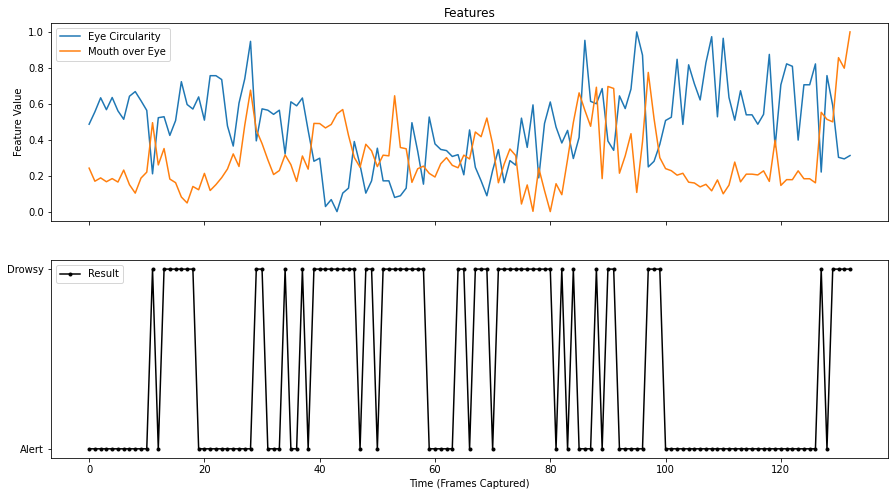

In [ ]:
features = np.vstack(features)
y = pd.DataFrame(features, columns=["EAR", "MAR", "Circularity", "MOE", "EAR_N", "MAR_N", "Circularity_N", "MOE_N"])
y = y.drop(columns=["EAR_N", "MAR_N", "Circularity_N", "MOE_N"])
x = y.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = pd.DataFrame(x_scaled, columns=["Eye Aspect Ratio", "Mouth Aspect Ratio", "Eye Circularity", "Mouth over Eye"])
y["Result"] = result

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(15, 8))

ax1.set_title("Features")
ax1.plot(y["Eye Circularity"], label="Eye Circularity")
ax1.plot(y["Mouth over Eye"], label="Mouth over Eye")
ax1.legend(loc="best")
ax1.set_ylabel('Feature Value')

ax2.plot(y["Result"], marker='.', color='black', label='Result')
ax2.set_xlabel('Time (Frames Captured)')
ax2.legend(loc="best")

plt.show()